# MP 1
### Emmanuel Gallegos
### CS 543: Computer Vision
### Prof. Svetlana Lazebnik
### University of Illinois Urbana Champaign

In [1]:
import time
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# useful constants
UP=0
RIGHT=1
DOWN=2
LEFT=3

BLUE=0
GREEN=1
RED=2

COLOR_1 = RED
COLOR_2 = GREEN
COLOR_DEF = BLUE

In [3]:
# set image paths
basic_img_dir = os.path.join(os.getcwd(), "data")
hires_img_dir = os.path.join(os.getcwd(), "data_hires")
basic_img_paths = [os.path.join(basic_img_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_img_paths = [os.path.join(hires_img_dir, img_path) for img_path in os.listdir(hires_img_dir)]
# make directory for colorized photos if it does not exist
basic_colorized_dir = os.path.join(basic_img_dir, "..", "basic_colorized")
if not os.path.exists(basic_colorized_dir):
    os.mkdir(basic_colorized_dir)
basic_colorized_paths = [os.path.join(basic_colorized_dir, img_path) for img_path in os.listdir(basic_img_dir)]
#hires_colorized_paths = [os.path.join(hires_img_dir, img_path) for img_path in os.listdir(hires_img_dir)]
print(basic_img_paths)
print(hires_img_paths)
print(basic_colorized_paths)

['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00125v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00149v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00153v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00351v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00398v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\01112v.jpg']
['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data_hires\\01047u.tif', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data_hires\\01657u.tif', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data_hires\\01861a.tif']
['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00125v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00149v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00153v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00351v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data

In [4]:
# roll a 2d image in a given direction (0->up, 1->right, 2->down, 3->left)
def roll_image(image, direction, n_pixels):
    if direction == UP:
        return np.roll(image, -n_pixels, axis=1)
    elif direction == DOWN:
        return np.roll(image, n_pixels, axis=1)
    elif direction == RIGHT:
        return np.roll(image, n_pixels, axis=0)
    elif direction == LEFT:
        return np.roll(image, -n_pixels, axis=0)

In [5]:
def align_image(bgr_image):
    # pad the images with 15 rows/cols of 255
    padded_channels = np.pad(bgr_channels,((0,0),(15,15),(15,15)), mode='constant', constant_values=255)
    # save shape of channel
    original_shape = padded_channels.shape
    # unroll the channels to 1d arrays
    unrolled_channels = padded_channels.reshape(3,-1)
    # get channel means
    means = np.mean(unrolled_channels, axis=1).reshape(-1,1)
    # subtract channel means to get mean 0 channels
    mean_0_channels = unrolled_channels - means
    # get channel norms
    norms = np.linalg.norm(mean_0_channels, axis=1).reshape(-1,1)
    # normalize channels
    norm_channels = mean_0_channels / norms  
  
    # fit alignment of color1 and color2 channels to default color channel through exhaustive search
    best_col_1_val, best_col_2_val = 0, 0
    best_col_1_disp = (0,0)
    best_col_2_disp = (0,0)
    
    # reshape normalized arrays to original shape
    norm_channels = norm_channels.reshape(original_shape)
    
    # roll color1 and color2 images up and to the left by 15 pixels
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, 15)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, 15)
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], LEFT, 15)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], LEFT, 15)
    # exhaustively search for best alignment
    # iterate over columns
    for i in range(-15, 16):
        # iterate over rows
        for j in range(-15, 16):
            # unroll
            norm_channels = norm_channels.reshape(3,-1)
            # check color1's fit to color default
            color_1_fit = np.dot(norm_channels[COLOR_1], norm_channels[COLOR_DEF])
            # check color2's fit to color default
            color_2_fit = np.dot(norm_channels[COLOR_DEF], norm_channels[COLOR_2])
            # reroll
            norm_channels = norm_channels.reshape(original_shape)     
            # update best displacements if needed
            if(color_1_fit > best_col_1_val):
                best_col_1_val = color_1_fit
                best_col_1_disp = (i,j)
            if(color_2_fit > best_col_2_val):
                best_col_2_val = color_2_fit
                best_col_2_disp = (i,j)
            # roll color1 and color2 images down 1 pixel
            norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], DOWN, 1)
            norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], DOWN, 1)
        # roll color1 and color2 images up by 31 pixels
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, 31)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, 31)
        # roll color1 and color2 images to right by 1 pixel
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], RIGHT, 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], RIGHT, 1)           
    
    # print displacement
    print("best color 1 displacement: " + str(best_col_1_disp))
    print("best color 2 displacement: " + str(best_col_2_disp))
    
    # roll original color 1 and color 2 images to optimal displacements
    padded_channels[COLOR_1] = roll_image(padded_channels[COLOR_1], RIGHT, best_col_1_disp[0])
    padded_channels[COLOR_1] = roll_image(padded_channels[COLOR_1], DOWN, best_col_1_disp[1])
    padded_channels[COLOR_2] = roll_image(padded_channels[COLOR_2], RIGHT, best_col_2_disp[0])
    padded_channels[COLOR_2] = roll_image(padded_channels[COLOR_2], DOWN, best_col_2_disp[1])
    
    # change stride to (r,c,3)
    bgr_image = padded_channels.transpose(1,2,0)
    # flip channels to rgb channels
    rgb_image = np.flip(bgr_image, axis=-1)
    
    return rgb_image

best color 1 displacement: (12, -2)
best color 2 displacement: (8, -1)
best color 1 displacement: (11, 1)
best color 2 displacement: (5, 1)
best color 1 displacement: (13, 3)
best color 2 displacement: (2, 2)
best color 1 displacement: (15, -1)
best color 2 displacement: (5, 0)
best color 1 displacement: (11, -2)
best color 2 displacement: (7, -1)
best color 1 displacement: (10, 3)
best color 2 displacement: (0, 1)


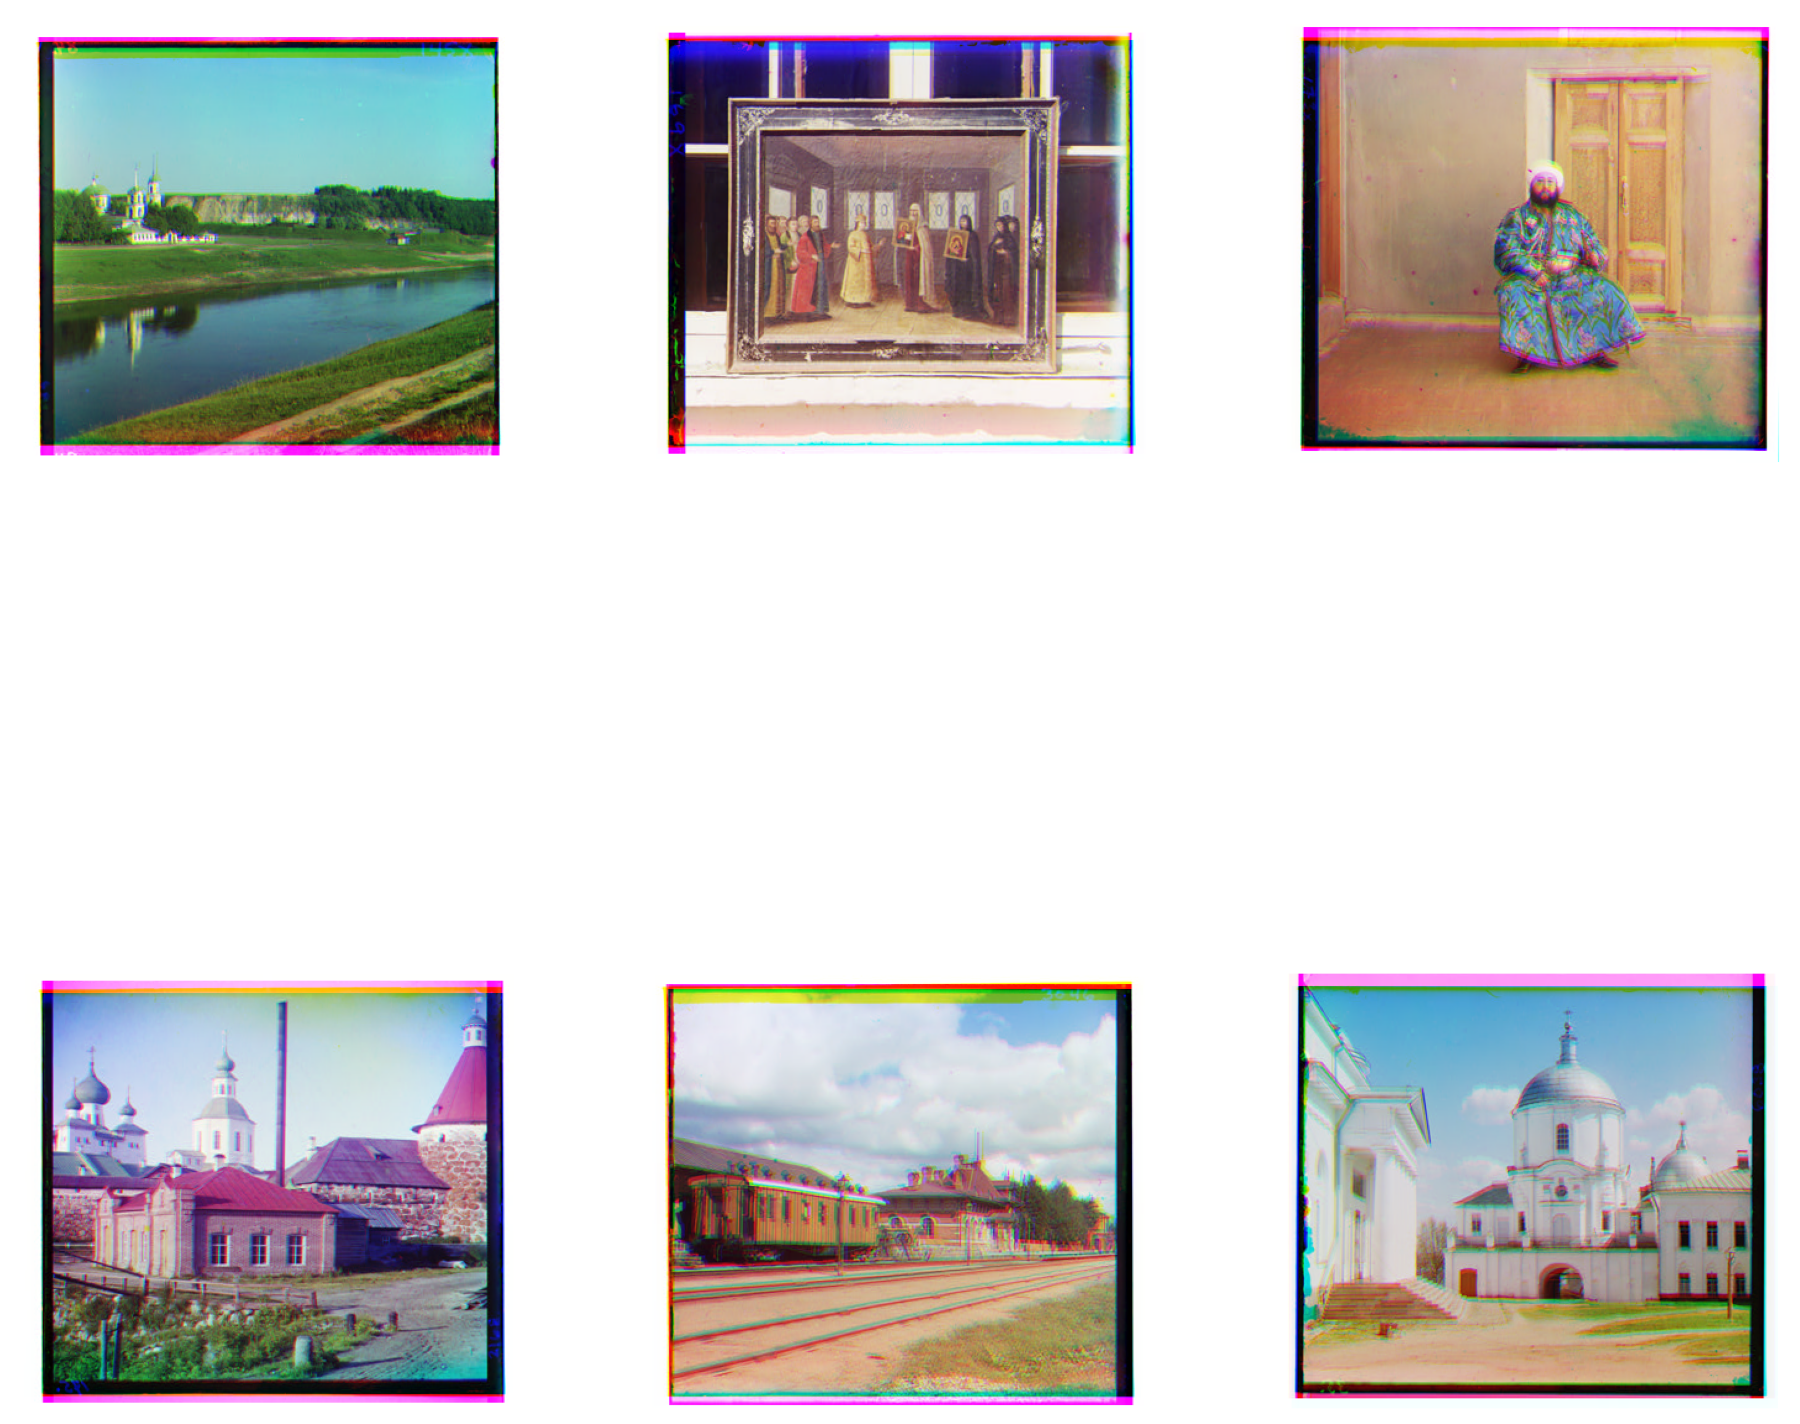

In [6]:
 # create figure
fig = plt.figure(figsize=(32, 32))
rows = 2
columns = 3

for n in range (0,len(basic_img_paths)): 
    # open image
    image = Image.open(basic_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=255)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    # align image
    rgb_image = align_image(bgr_channels)
    # display image
    fig.add_subplot(rows, columns, n+1)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    im = Image.fromarray(rgb_image)
    im.save(basic_colorized_paths[n])